- generate random objects of different signal absorption rate
- generate random lines between points outside of these objects
- draw lines into estimation image based on the average signal absorption along the line

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import correlation

In [2]:
# area size
length = 130
# area margin at the border where no objects are placed
margin_border = 2

# object size
min_size = 3
max_size = 20
# object absorbtion rates
min_absorption = 3
max_absorption = 20
# number of objects placed in area
n_objs = 100

# number of measurement lines placed in area
n_lines = 100000

# percentages of used lines at which we plot and measure eastimations
number_of_lines_estimation = [100, 500, 1000, 5000, 10000, 20000, 50000, 100000]
# signal losses to plot and measure estimations at
signal_losses_estimation = [200, 1000]

In [3]:
class Object:
    def __init__(self):
        self.width = random.randint(min_size, max_size)
        self.height = random.randint(min_size, max_size)
        self.x = random.randint(margin_border, length-margin_border-self.width)
        self.y = random.randint(margin_border, length-margin_border-self.height)
        self.absorption = random.randint(min_absorption, max_absorption)

def get_pos(border, pos):
    if border == 0:
        return pos, 0
    if border == 1:
        return length-1, pos
    if border == 2:
        return pos, length-1
    return 0, pos
    
class LineBorder:
    def __init__(self):
        borders = random.sample(range(-1, 3), 2)
        pos = (random.randint(0, length-1), random.randint(0, length-1))
        x0, y0 = get_pos(borders[0], pos[0])
        x1, y1 = get_pos(borders[1], pos[1])
        self.length = int(np.hypot(x1-x0, y1-y0))
        self.x, self.y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)
        
class LineOutsideObjects:
    def __init__(self, background_positions):
        positions = random.sample(background_positions, 2)
        x0, y0 = positions[0]
        x1, y1 = positions[1]
        self.length = int(np.hypot(x1-x0, y1-y0))
        self.x, self.y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)
        
def get_val(val, absorbtion):
    if val < 0:
        return absorbtion
    return min(val, absorbtion_sum)
        
        
# for each pixel in the estimation image, the minimum absorbtion value of all lines passing this pixel is taken
def accumulate_lines_min(lines, num_lines, signal_lost_threshold=None):
    res = []
    mins = np.zeros(shape=(length, length), dtype=float)
    mins[:,:] = -1
    for line_i, line in enumerate(lines):
        for num_line in num_lines:
            if num_line-1 == line_i:
                out = np.copy(mins)
                res.append(out)
        values = gt[line.x.astype(int), line.y.astype(int)]
        num_values = len(values)
        absorbtion_sum = np.sum(values)
        if signal_lost_threshold is not None and absorbtion_sum > signal_lost_threshold:
            # the signal is completely absorbed along the way
            absorbtion_sum = signal_lost_threshold
        myfilter = np.zeros(shape=(length, length), dtype=bool)
        myfilter[line.x.astype(int), line.y.astype(int)] = True
        mins[myfilter] = np.minimum(mins[myfilter], absorbtion_sum)
        mins[myfilter & (mins < 0)] = absorbtion_sum
    return res


# for each pixel in the estimation image, the average absorbtion value of all lines passing this pixel is taken
def accumulate_lines_avg(lines, num_lines, signal_lost_threshold=None):
    res = []
    sums = np.zeros(shape=(length, length), dtype=float)
    counts = np.zeros(shape=(length, length), dtype=float)
    for line_i, line in enumerate(lines):
        for num_line in num_lines:
            if num_line-1 == line_i:
                out = np.copy(sums)
                out[counts > 0] = out[counts > 0] / counts[counts > 0]
                res.append(out)
        values = gt[line.x.astype(int), line.y.astype(int)]
        num_values = len(values)
        absorbtion_sum = np.sum(values)
        if signal_lost_threshold is not None and absorbtion_sum > signal_lost_threshold:
            # the signal is completely absorbed along the way
            absorbtion_sum = signal_lost_threshold
        sums[line.x.astype(int), line.y.astype(int)] += absorbtion_sum
        counts[line.x.astype(int), line.y.astype(int)] += 1

    return res

In [4]:
random_objs = [Object() for i in range(n_objs)]

In [5]:
gt = np.zeros(shape=(length, length), dtype=int)
for obj in random_objs:
    gt[obj.x:obj.x+obj.width, obj.y:obj.y+obj.height] = obj.absorption

## Measuring from outside

All measurement lines in the next section start and end on the boundary of the area.

In [6]:
random_lines_border = [LineBorder() for i in range(n_lines)]

In [7]:
line_estimates_border = accumulate_lines_avg(random_lines_border, number_of_lines_estimation)

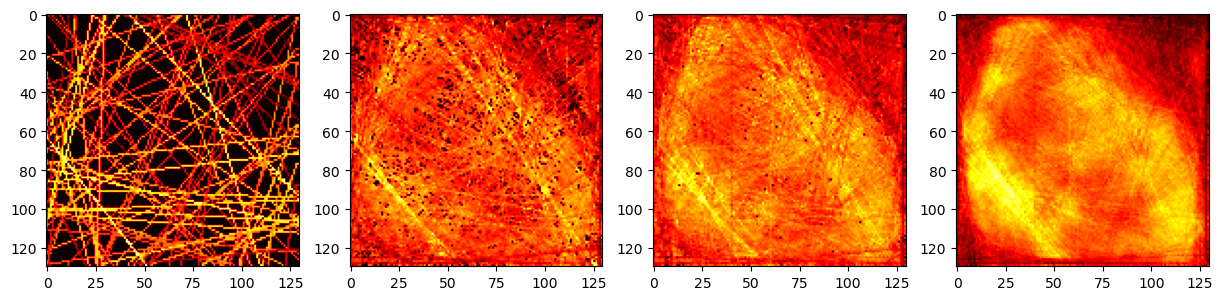

In [8]:
fig, axes = plt.subplots(ncols=4, figsize=(15, 15))
axes[0].imshow(line_estimates_border[0], cmap='hot')
axes[1].imshow(line_estimates_border[1], cmap='hot')
axes[2].imshow(line_estimates_border[2], cmap='hot')
axes[3].imshow(line_estimates_border[3], cmap='hot')
plt.show()

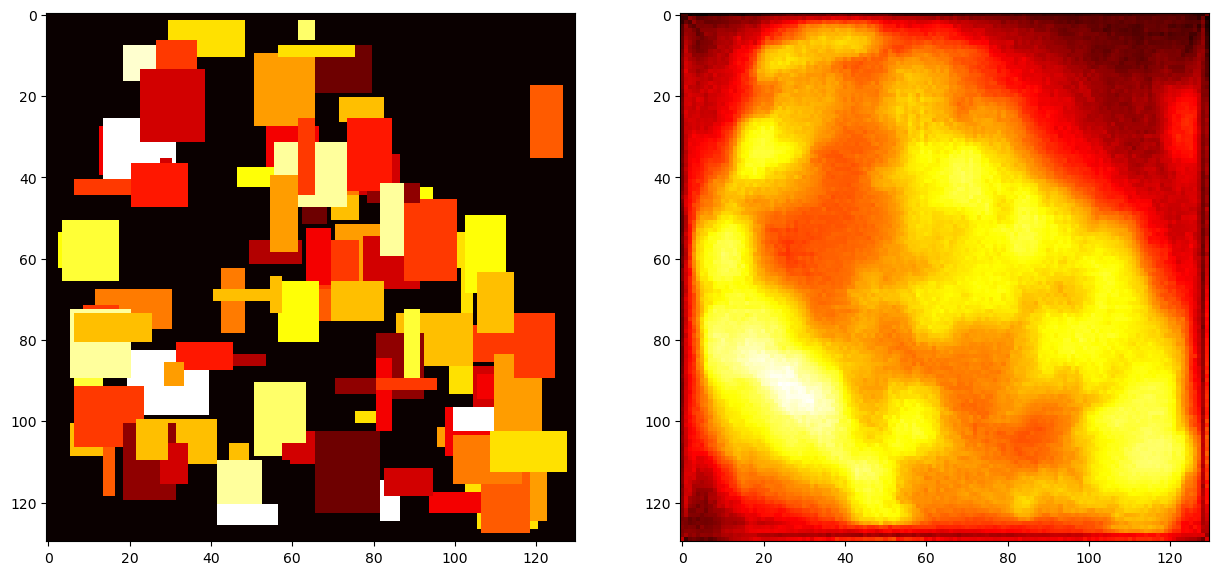

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 15))
axes[0].imshow(gt, cmap='hot')
axes[1].imshow(line_estimates_border[len(number_of_lines_estimation)-1], cmap='hot')
plt.show()

## Adding signal loss

The absorbtion rate along lines is clipped at a specific value - higher absorbtion equals signal loss and can't be measured.

In [10]:
line_estimates_border_losses = [accumulate_lines_avg(random_lines_border, number_of_lines_estimation, signal_lost_threshold=threshold) for threshold in signal_losses_estimation]

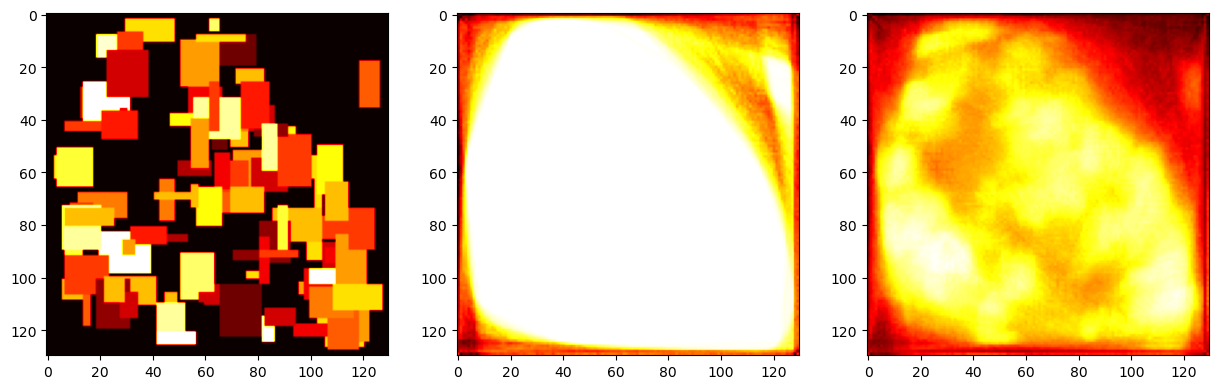

In [11]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 15))
axes[0].imshow(gt, cmap='hot')
axes[1].imshow(line_estimates_border_losses[0][len(number_of_lines_estimation)-1], cmap='hot')
axes[2].imshow(line_estimates_border_losses[1][len(number_of_lines_estimation)-1], cmap='hot')
plt.show()

## Measuring from anywhere
What if measurements can be taken between any two points in the area, not just the boundary?

In [12]:
background_positions = np.argwhere(gt==0).tolist()
random_lines_anywhere = [LineOutsideObjects(background_positions) for i in range(n_lines)]

In [13]:
line_estimates_anywhere = accumulate_lines_avg(random_lines_anywhere, number_of_lines_estimation)

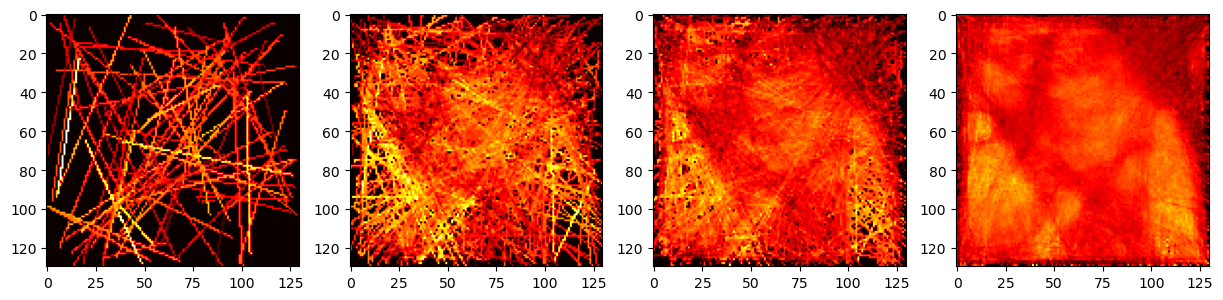

In [14]:
fig, axes = plt.subplots(ncols=4, figsize=(15, 15))
axes[0].imshow(line_estimates_anywhere[0], cmap='hot')
axes[1].imshow(line_estimates_anywhere[1], cmap='hot')
axes[2].imshow(line_estimates_anywhere[2], cmap='hot')
axes[3].imshow(line_estimates_anywhere[3], cmap='hot')
plt.show()

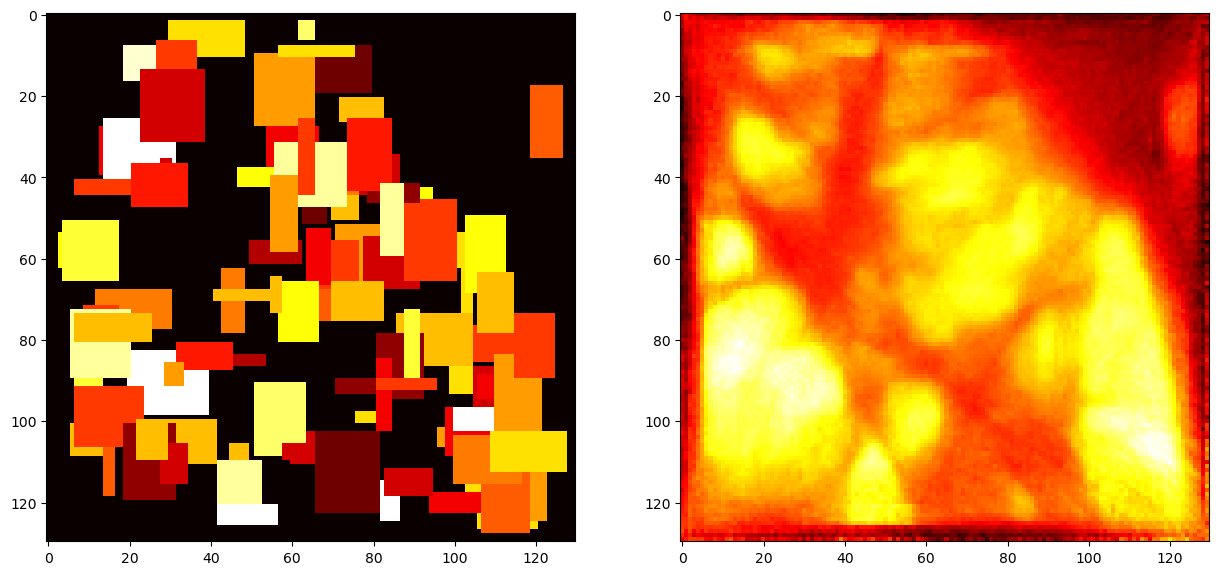

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 15))
im0 = axes[0].imshow(gt, cmap='hot')
im1 = axes[1].imshow(line_estimates_anywhere[len(number_of_lines_estimation)-1], cmap='hot')
plt.show()

## Measuring from anywhere with signal loss

In [16]:
line_estimates_anywhere_losses = [accumulate_lines_avg(random_lines_anywhere, number_of_lines_estimation, signal_lost_threshold=threshold) for threshold in signal_losses_estimation]

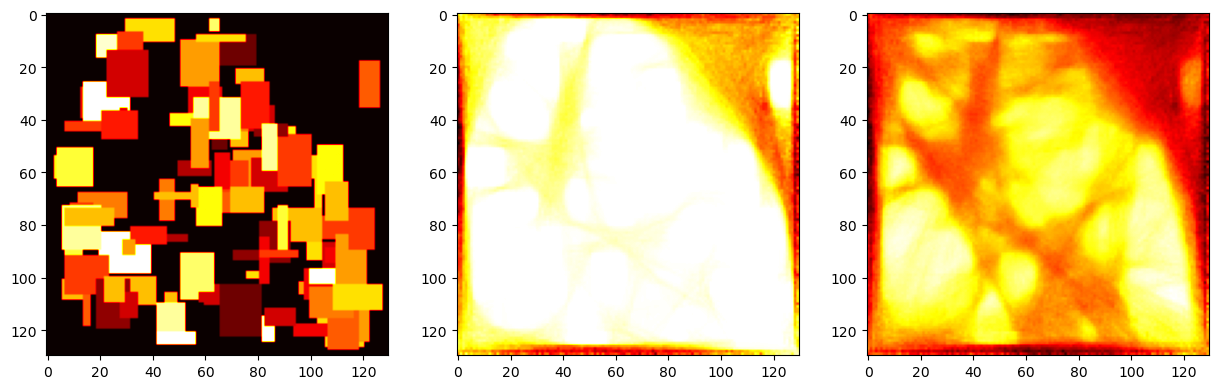

In [17]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 15))
axes[0].imshow(gt, cmap='hot')
axes[1].imshow(line_estimates_anywhere_losses[0][len(number_of_lines_estimation)-1], cmap='hot')
axes[2].imshow(line_estimates_anywhere_losses[1][len(number_of_lines_estimation)-1], cmap='hot')
plt.show()

## Minimum absorbtion rate instead of average absorbtion rate
For each pixel in the estimation image, we now switch from calculating the average absorbtion rate of all measurement lines passing this pixel to calculating the minimum absorbtion rate.

In [18]:
line_estimates_border_min = accumulate_lines_min(random_lines_border, number_of_lines_estimation)
line_estimates_anywhere_min = accumulate_lines_min(random_lines_anywhere, number_of_lines_estimation)

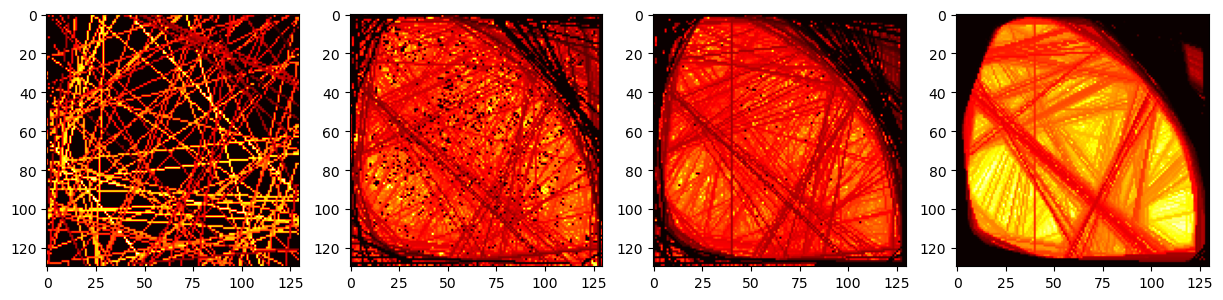

In [33]:
fig, axes = plt.subplots(ncols=4, figsize=(15, 15))
axes[0].imshow(line_estimates_border_min[0], cmap='hot')
axes[1].imshow(line_estimates_border_min[1], cmap='hot')
axes[2].imshow(line_estimates_border_min[2], cmap='hot')
axes[3].imshow(line_estimates_border_min[3], cmap='hot')
plt.show()

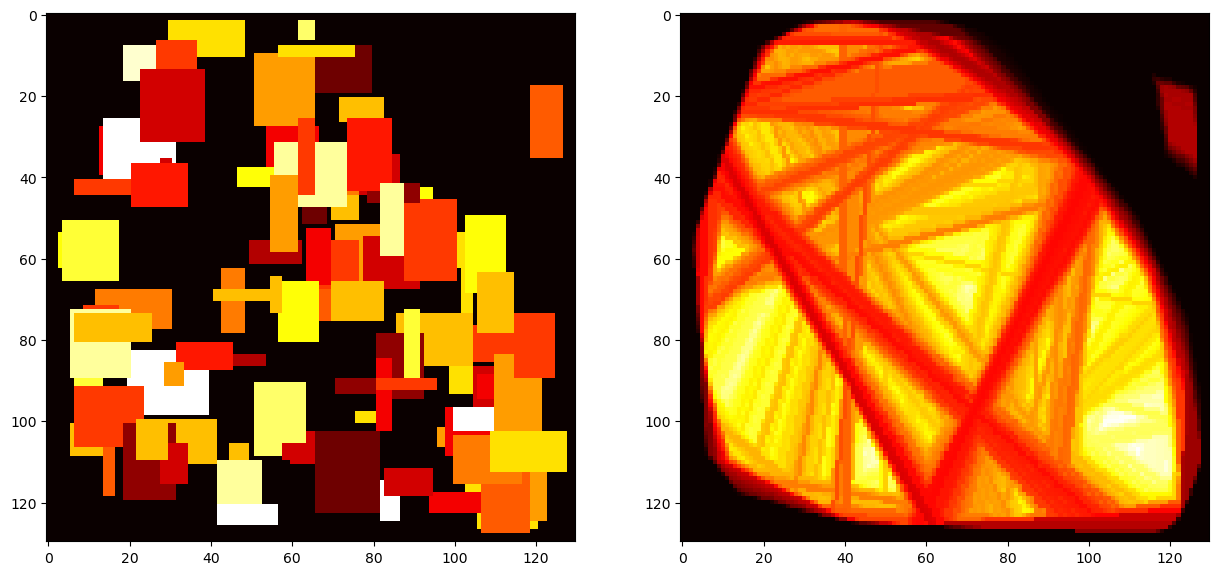

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 15))
im0 = axes[0].imshow(gt, cmap='hot')
im1 = axes[1].imshow(line_estimates_border_min[len(number_of_lines_estimation)-1], cmap='hot')
plt.show()

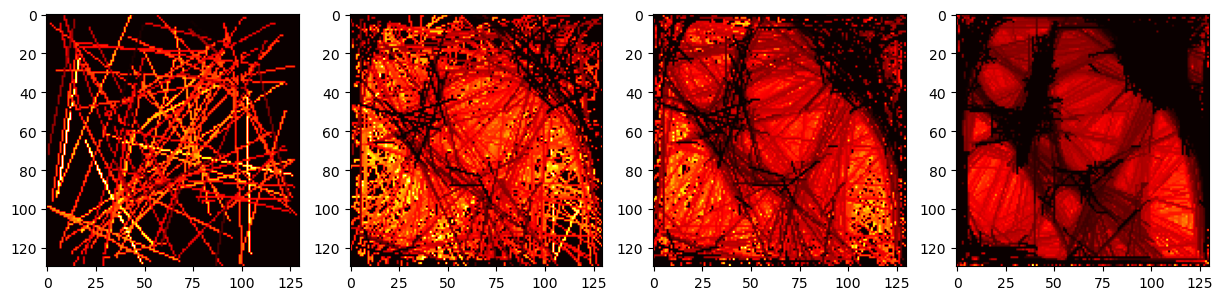

In [31]:
fig, axes = plt.subplots(ncols=4, figsize=(15, 15))
axes[0].imshow(line_estimates_anywhere_min[0], cmap='hot')
axes[1].imshow(line_estimates_anywhere_min[1], cmap='hot')
axes[2].imshow(line_estimates_anywhere_min[2], cmap='hot')
axes[3].imshow(line_estimates_anywhere_min[3], cmap='hot')
plt.show()

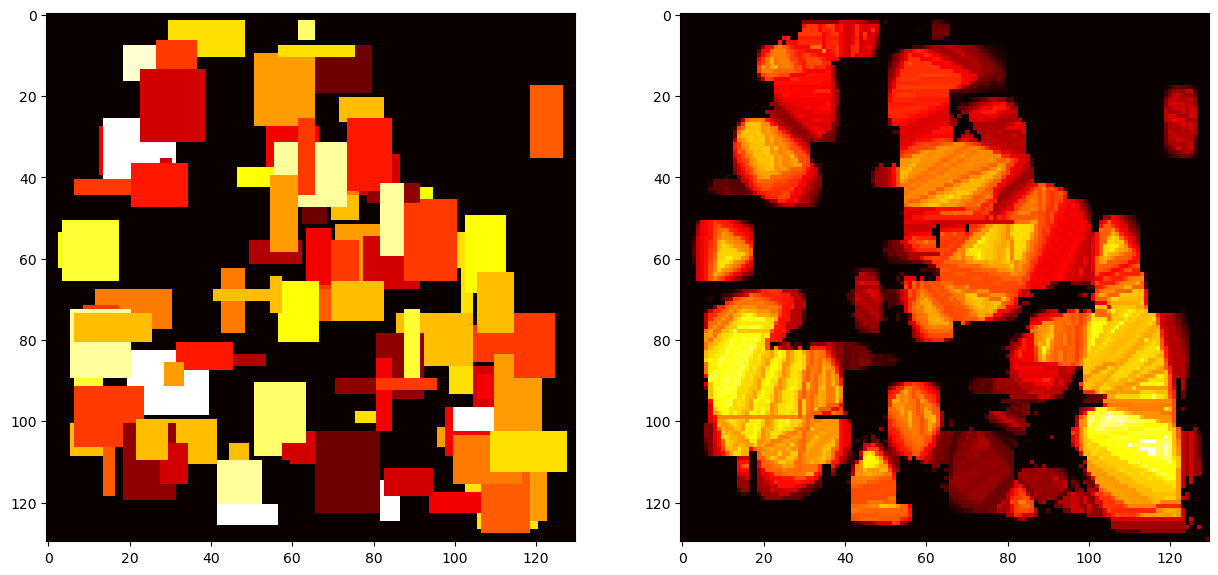

In [32]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 15))
im0 = axes[0].imshow(gt, cmap='hot')
im1 = axes[1].imshow(line_estimates_anywhere_min[len(number_of_lines_estimation)-1], cmap='hot')
plt.show()

## Correlation

In [20]:
correlation_baseline = [correlation(gt.flatten(),gt.flatten()) for estimation in line_estimates_border]

In [21]:
correlation_border = [correlation(gt.flatten(),estimation.flatten()) for estimation in line_estimates_border]
correlation_border_losses = [[correlation(gt.flatten(),estimation.flatten()) for estimation in losses] for losses in line_estimates_border_losses]

In [22]:
correlation_anywhere = [correlation(gt.flatten(),estimation.flatten()) for estimation in line_estimates_anywhere]
correlation_anywhere_losses = [[correlation(gt.flatten(),estimation.flatten()) for estimation in losses] for losses in line_estimates_anywhere_losses]

In [23]:
correlation_anywhere_min = [correlation(gt.flatten(),estimation.flatten()) for estimation in line_estimates_anywhere_min]
correlation_border_min = [correlation(gt.flatten(),estimation.flatten()) for estimation in line_estimates_border_min]

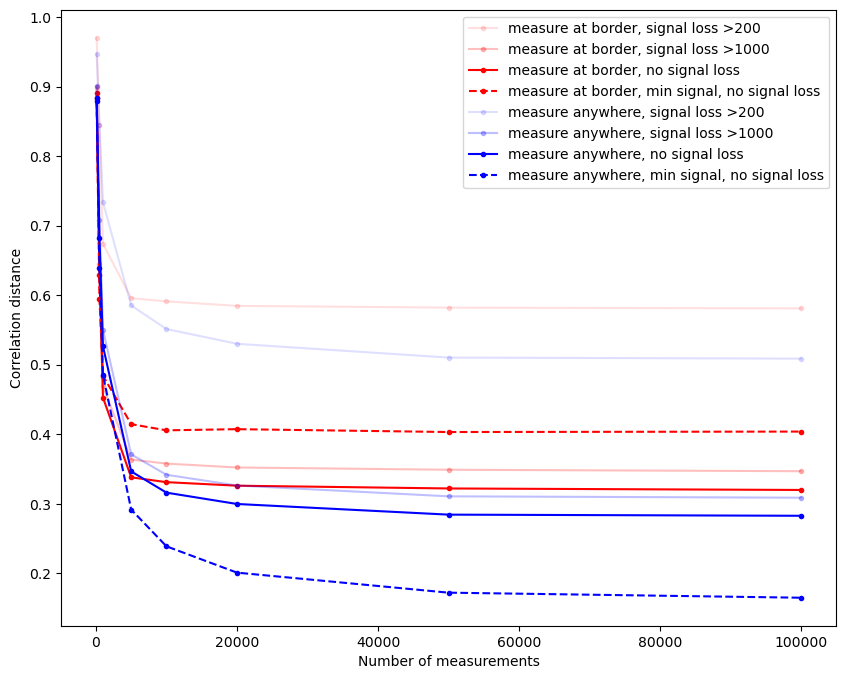

In [30]:
fig, ax = plt.subplots(ncols=1, figsize=(10,8))
# ax.plot(number_of_lines_estimation, correlation_baseline, label="baseline")
for i, loss in enumerate(correlation_border_losses):
    ax.plot(number_of_lines_estimation, loss, marker='.', color='red', alpha=float(float(i+1)/float(len(loss))), label="measure at border, signal loss >" + str(signal_losses_estimation[i]))
ax.plot(number_of_lines_estimation, correlation_border, marker='.', label="measure at border, no signal loss", color='red')
ax.plot(number_of_lines_estimation, correlation_border_min, linestyle='dashed', marker='.', color='red', label="measure at border, min signal, no signal loss")
for i, loss in enumerate(correlation_anywhere_losses):
    ax.plot(number_of_lines_estimation, loss, marker='.', color='blue', alpha=float(float(i+1)/float(len(loss))), label="measure anywhere, signal loss >" + str(signal_losses_estimation[i]))
ax.plot(number_of_lines_estimation, correlation_anywhere, marker='.', color='blue', label="measure anywhere, no signal loss")
ax.plot(number_of_lines_estimation, correlation_anywhere_min, linestyle='dashed', marker='.', color='blue', label="measure anywhere, min signal, no signal loss")
ax.set_xlabel('Number of measurements')
ax.set_ylabel('Correlation distance')
plt.legend()
plt.show()